## Analyse coefficients dynamiques

Alexandre Castanié

---

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

In [3]:
#Récupération des données de la CRE
CoeffsCRE=pd.read_excel("2eme semestre 2022.xlsx",sheet_name=-1,skiprows=2)
CoeffsCRE = CoeffsCRE.set_index('Horodate')
CoeffsCRE.index = pd.to_datetime(CoeffsCRE.index)

Les données de la CRE sont composées des profils dynamiques i.e. des courbes de charge prévisionnelles à température normale et des gradients de température i.e. des coefficients qui permettent de prendre en compte les variations de température. Ces grandeurs s'expriment au pas du règlement des écarts fixé à 30 min pour l'instant depuis le 1er janvier 2022.  
Pour chaque profil bleu, il est donné deux ensembles de paires de valeurs correspondants chacun à un lissage de température différent. Chaque ensemble est distingué par les appellations "1ère année de lissage" et "2ème année de lissage".

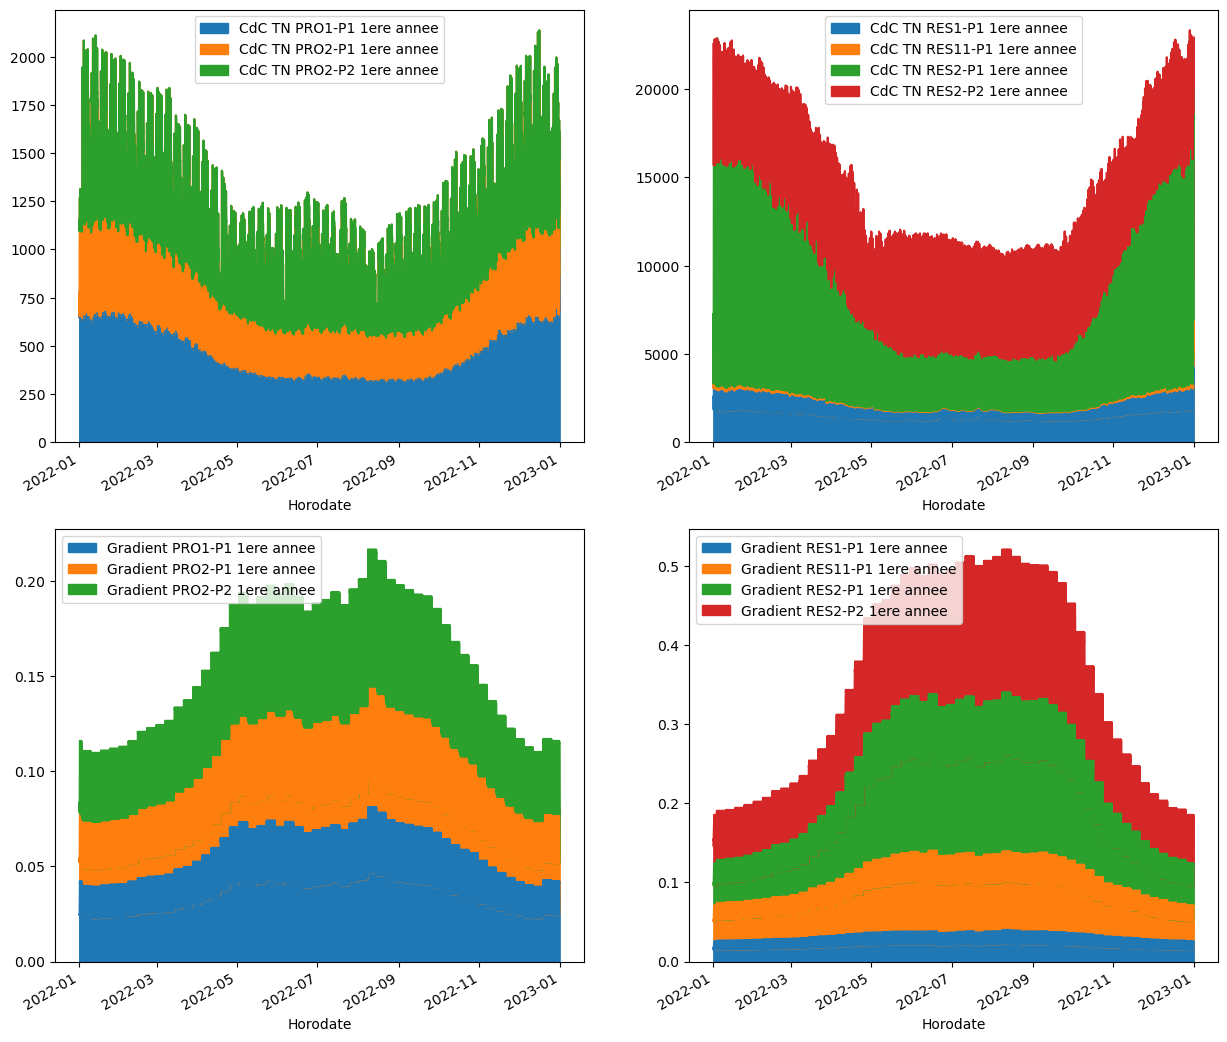

In [4]:
#Tracé données
fig,axs=plt.subplots(2,2,figsize=(15,14))
CoeffsCRE.plot.area(y=['CdC TN PRO1-P1 1ere annee','CdC TN PRO2-P1 1ere annee','CdC TN PRO2-P2 1ere annee'],ax=axs[0,0])
CoeffsCRE.plot.area(y=['CdC TN RES1-P1 1ere annee','CdC TN RES11-P1 1ere annee','CdC TN RES2-P1 1ere annee',
'CdC TN RES2-P2 1ere annee'],ax=axs[0,1])
CoeffsCRE.plot.area(y=['Gradient PRO1-P1 1ere annee','Gradient PRO2-P1 1ere annee','Gradient PRO2-P2 1ere annee'],ax=axs[1,0])
CoeffsCRE.plot.area(y=['Gradient RES1-P1 1ere annee','Gradient RES11-P1 1ere annee','Gradient RES2-P1 1ere annee',
'Gradient RES2-P2 1ere annee'],ax=axs[1,1])
plt.show()

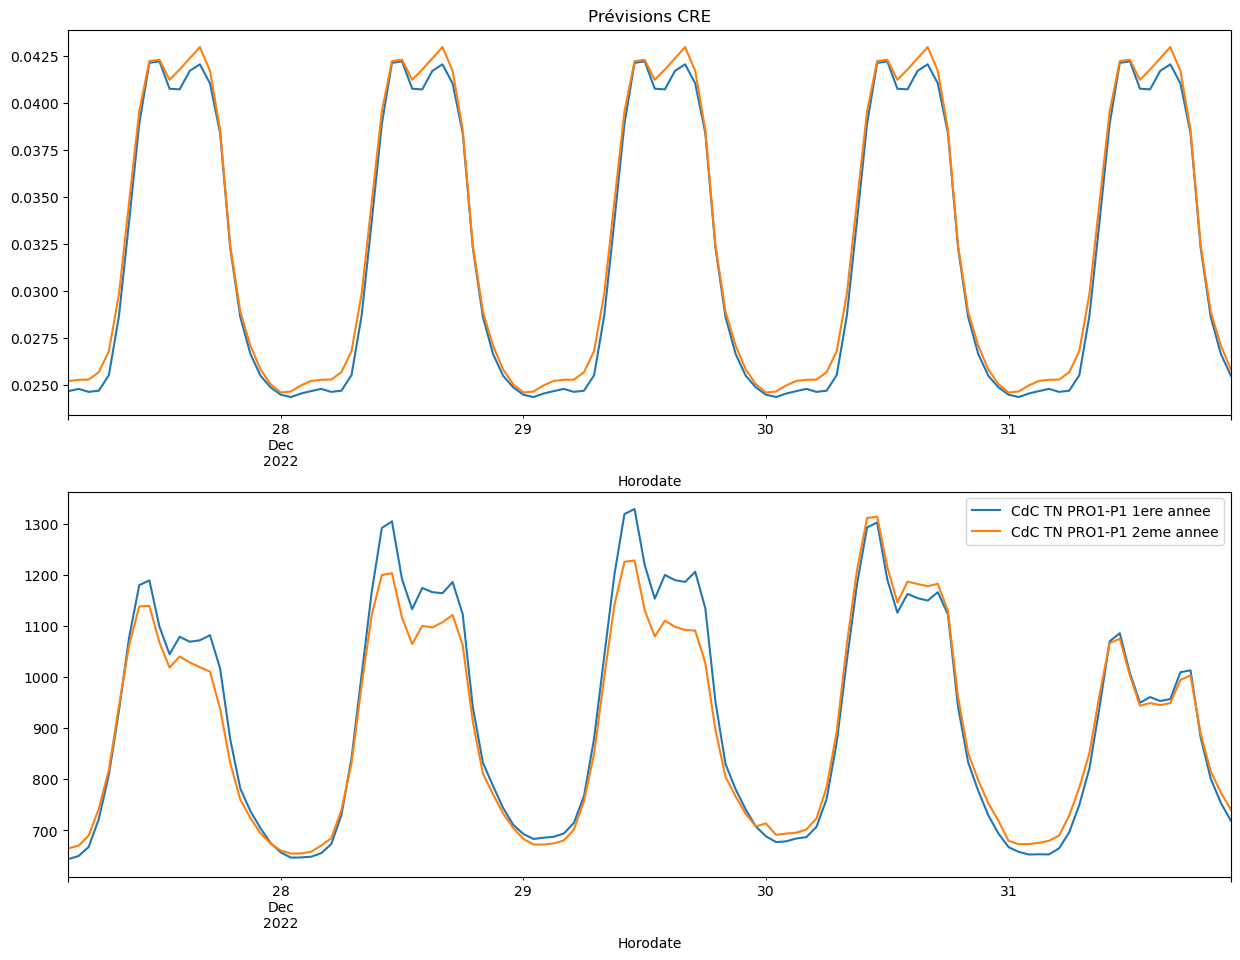

In [12]:
fig,axs=plt.subplots(2,1,figsize=(15,11))
CoeffsCRE['Gradient PRO1-P1 1ere annee'].loc[(CoeffsCRE.index > pd.to_datetime('2022-12-27T01:00:00.000Z')) & 
(CoeffsCRE.index < pd.to_datetime('2022-12-31T22:00:00.000Z'))].plot(ax=axs[0], title='Prévisions CRE')
CoeffsCRE['Gradient PRO1-P1 2eme annee'].loc[(CoeffsCRE.index > pd.to_datetime('2022-12-27T01:00:00.000Z')) & 
(CoeffsCRE.index < pd.to_datetime('2022-12-31T22:00:00.000Z'))].plot(ax=axs[0])
CoeffsCRE['CdC TN PRO1-P1 1ere annee'].loc[(CoeffsCRE.index > pd.to_datetime('2022-12-27T01:00:00.000Z')) & 
(CoeffsCRE.index < pd.to_datetime('2022-12-31T22:00:00.000Z'))].plot(ax=axs[1])
CoeffsCRE['CdC TN PRO1-P1 2eme annee'].loc[(CoeffsCRE.index > pd.to_datetime('2022-12-27T01:00:00.000Z')) & 
(CoeffsCRE.index < pd.to_datetime('2022-12-31T22:00:00.000Z'))].plot(ax=axs[1])
plt.legend()
plt.show()

Partant des historiques de sous-profils dynamiques publiés sur le site d’Enedis, le modèle de la CRE procède en trois étapes :
- Etape 1 : calcul des gradients de température
- Etape 2 : retraitement des données historiques pour les ramener à température normale et estimation des paramètres du profil
- Etape 3 : calibration de modèles stochastiques permettant de générer des scénarios d’écart entre consommation réalisée à température normale et profil à température normale.

<ins> Gradient de température : </ins>

Sur une plage de température majorée par une température seuil (15°C), RTE a remarqué une relation de proportionnalité entre la variation de la température et celle de la consommation. Le coefficient exprimant cette relation est appelé "gradient de température". Comme il est indiqué en annexe de la section F des règles MA-RE, il traduit ainsi la variation de consommation liée à une variation de 1°C de température. Il faut également prendre en compte "l'inertie" des variations de consommation sur les variations de température (principalement due à l'inertie thermique des bâtiments). Cet effet est modélisé par un décalage et une atténuation de l'amplitude des variations de température appellés par RTE "lissage des températures".

Le calcul du gradient pour chaque demi-heure se base sur la méthode "par delta" utilisée par RTE et détaillée dans les règles du mécanisme de capacité. Il consiste à éffectuer un regression linéaire sur une consommation en fonction d'une température lissée seuillée qui ne prennent pas en compte certains points particuliers (jours fériés, vacances scolaires,...).

<ins> Coefficients de consommation des années précédentes à température normale hebdomadaires et maj du gradient : </ins>

Le calcul des coefficients de consommation à température normale hebdomadaires se base sur les coefficients dynamiques fournis par ENEDIS. L'idée est d'effectuer la moyenne des valeurs historiques auxquelles on a retranché la consommation correspondant à la différence entre la température "réalisée" (= température mesurée par ENEDIS) et la température normale seuillée. Un nouveau gradient est ensuite déterminé pour chaque semaine et chaque demi-heure en calculant le produit entre le gradient précédent et le coefficient hebdomadaire tout juste calculé.

<ins> Courbe de charge prévisionnelle et écarts </ins>

La courbe de charge historique à température normale va maintenant être normalisée pour avoir une moyenne égale à 1 puis moyennée pour avoir un profil hebdomadaire, journalier et demi-horaire. On obtient alors les coefficients de ce profil en le multipliant aux coefficients hebdomadaires calculés précédemment. Grâce aux différents paramètres calculés, la consommation (ou courbe de charge) d'abord à température normale puis à température réalisée peut-être déterminée.  

La CRE propose ensuite d'évaluer l'écart entre la courbe de charge prévisionnelle et celle historique à température normale. L'étude de cet écart appelé "résidu" permet de générer des scénarios de courbes de charge pour chaque sous-profil de consommation. La CRE propose également un requalibrage de la courbe de charge en prenant en compte la relève mensuelle des données de consommations grâce aux compteurs Linky.

In [ ]:
gen=pd.read_csv("coefficients-des-profils.csv",sep=";",usecols=["HORODATE","SOUS_PROFIL",
"COEFFICIENT_PREPARE","COEFFICIENT_AJUSTE","COEFFICIENT_DYNAMIQUE"],chunksize=90000)
CoeffsENEDIS_RES11=pd.concat((x.query("SOUS_PROFIL == 'RES11_BASE'") for x in gen), ignore_index=True)